# Images classification with AutoML for Images (Azure ML)

The code outlines a Python-based setup for training and deploying models using Azure Machine Learning, with tools for AutoML, MLflow tracking, and environment configuration.

## Model training

<img src="img/automl.png">

### 🔧 Environment Setup
The script imports a wide range of libraries for:
- Data handling: pandas, json, datetime, os, sys
- Visualization: matplotlib.pyplot, matplotlib.image, PIL.Image
- Azure ML SDK: azure.ai.ml, including modules for automl, entities, sweep, and constants
- Authentication: DefaultAzureCredential from azure.identity
- Environment variables: dotenv
- MLflow tracking: mlflow, MlflowClient

### 🧠 Model Training

The script likely involves:
- Automated machine learning (AutoML) using Azure ML
- Sweep configurations for hyperparameter tuning (e.g., BanditPolicy, Choice, Uniform)
- Deployment setup for online endpoints (ManagedOnlineDeployment, OnlineRequestSettings, etc.)
- Model testing

## 1. Settings

In [2]:
import asyncio
import base64
import datetime
import gradio as gr
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import mlflow
import os
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time

from azure.ai.ml import MLClient, Input, automl
from azure.ai.ml.automl import SearchSpace, ClassificationPrimaryMetrics
from azure.ai.ml.constants import AssetTypes, InputOutputModes
from azure.ai.ml.entities import (
    AmlCompute,
    CodeConfiguration,
    Data,
    Environment,
    ManagedOnlineDeployment,
    ManagedOnlineEndpoint,
    Model,
    OnlineRequestSettings,
    ProbeSettings,
)
from azure.ai.ml.sweep import BanditPolicy, Choice, Uniform
from azure.core.exceptions import ResourceNotFoundError
from azure.identity import DefaultAzureCredential
from dotenv import load_dotenv
from io import BytesIO
from mlflow.tracking.client import MlflowClient
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import classification_report

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 14-Oct-2025 13:50:34


In [4]:
print("Python version =", sys.version)

Python version = 3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]


In [5]:
IMAGES_DIR = "images"

In [6]:
TRAIN_DIR = os.path.join(IMAGES_DIR, "metaldefect", "train")
TEST_DIR = os.path.join(IMAGES_DIR, "metaldefect", "test")

In [7]:
MODEL_DIR = "models"

os.makedirs(MODEL_DIR, exist_ok=True)

In [8]:
RESULTS_DIR = "results"

os.makedirs(RESULTS_DIR, exist_ok=True)

In [9]:
# Azure ML job to create
exp_name = "metal-defect-classautomlimages"

In [10]:
load_dotenv("azure.env")

True

## 2. Configure Azure ML workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace.

In [11]:
print("Connection to the Azure ML workspace...")

credential = DefaultAzureCredential()

ml_client = MLClient(credential,
                     os.getenv("subscription_id"),
                     os.getenv("resource_group"),
                     os.getenv("workspace")
                     )

print("\n✅ Done")

Connection to the Azure ML workspace...

✅ Done


## 3. Images dataset


In [12]:
extensions = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}

nb_images = 0

for root, _, files in os.walk(TRAIN_DIR):
    nb = sum(1 for file in files
             if os.path.splitext(file)[1].lower() in extensions)
    if nb > 0:
        print(f"{root:40} = {nb} images")
    nb_images += nb

print(f"\n>> 🖼️ Total number of training images files = {nb_images}")

images/metaldefect/train/Crazing         = 200 images
images/metaldefect/train/Inclusion       = 200 images
images/metaldefect/train/Patches         = 200 images
images/metaldefect/train/Pitted          = 200 images
images/metaldefect/train/Rolled          = 200 images
images/metaldefect/train/Scratches       = 200 images

>> 🖼️ Total number of training images files = 1200


In [13]:
nb_images = 0

for root, _, files in os.walk(TEST_DIR):
    nb = sum(1 for file in files
             if os.path.splitext(file)[1].lower() in extensions)
    if nb > 0:
        print(f"{root:40} = {nb} images")
    nb_images += nb

print(f"\n>> 🖼️ Total number of testing images files = {nb_images}")

images/metaldefect/test/Crazing          = 30 images
images/metaldefect/test/Inclusion        = 30 images
images/metaldefect/test/Patches          = 30 images
images/metaldefect/test/Pitted           = 30 images
images/metaldefect/test/Rolled           = 30 images
images/metaldefect/test/Scratches        = 30 images

>> 🖼️ Total number of testing images files = 180



images/metaldefect/train/Crazing - showing first 5 image(s)


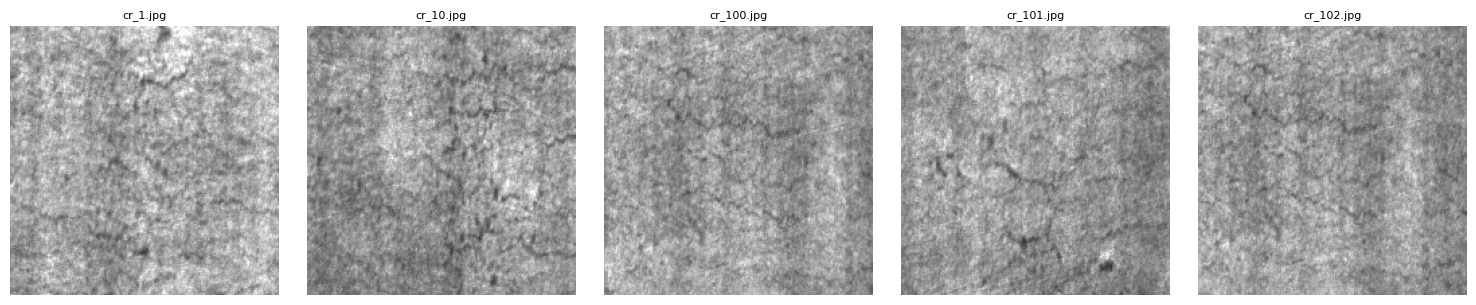


images/metaldefect/train/Inclusion - showing first 5 image(s)


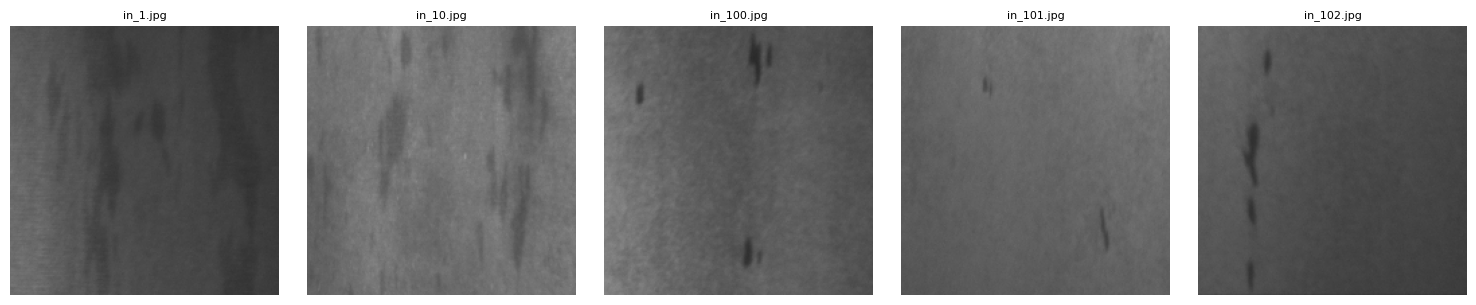


images/metaldefect/train/Patches - showing first 5 image(s)


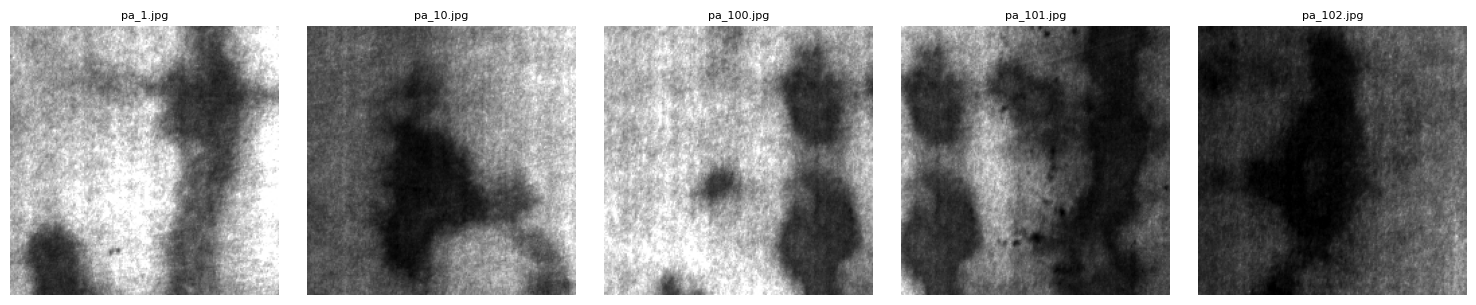


images/metaldefect/train/Pitted - showing first 5 image(s)


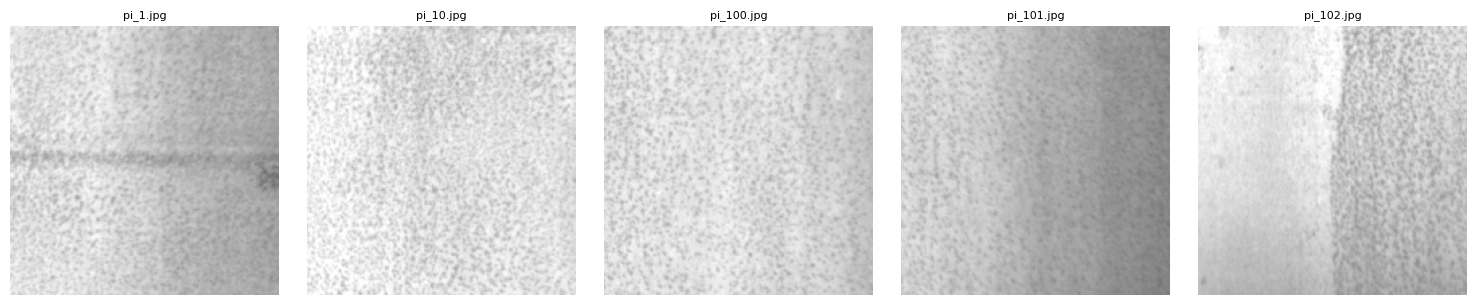


images/metaldefect/train/Rolled - showing first 5 image(s)


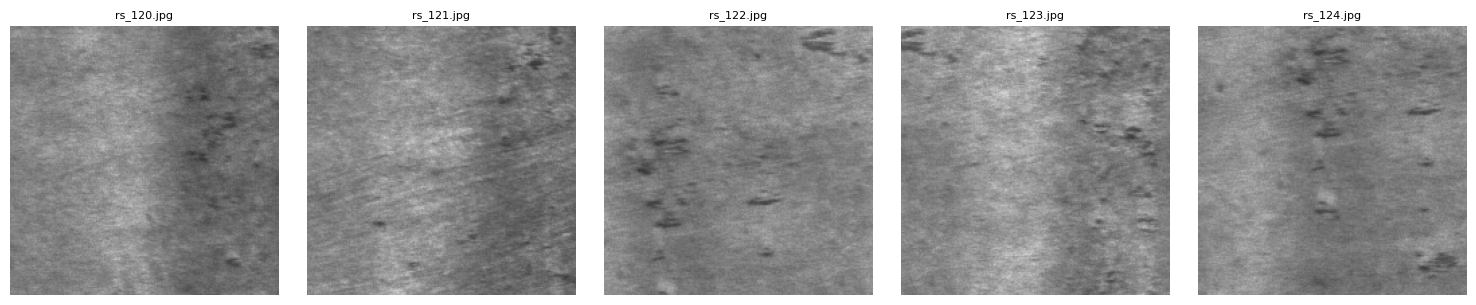


images/metaldefect/train/Scratches - showing first 5 image(s)


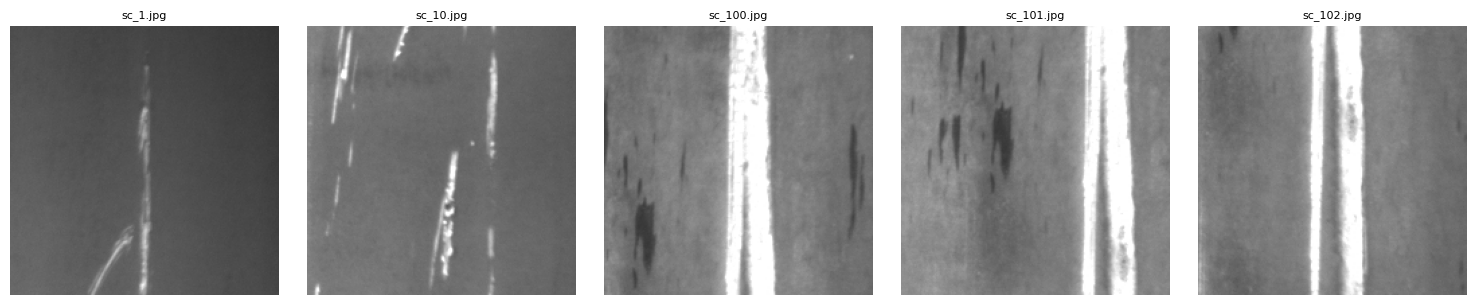

In [14]:
directory = Path(TRAIN_DIR)

for subdir, _, files in os.walk(directory):
    subdir_path = Path(subdir)
    image_files = [
        subdir_path / f for f in files if Path(f).suffix.lower() in extensions
    ]
    if image_files:
        print(
            f"\n{subdir} - showing first {min(5, len(image_files))} image(s)")

        fig, axes = plt.subplots(1, min(5, len(image_files)), figsize=(15, 3))
        if len(image_files) == 1:
            axes = [axes]

        for ax, img_path in zip(axes, image_files[:5]):
            img = mpimg.imread(img_path)
            ax.imshow(img)
            ax.set_title(img_path.name, fontsize=8)
            ax.axis("off")

        plt.tight_layout()
        plt.show()

### Upload the images to Datastore through an AML Data asset (URI Folder)

In [15]:
my_images = Data(
    path=TRAIN_DIR,
    type=AssetTypes.URI_FOLDER,
    description="Metal defects images for images classification",
    name="metaldefectimagesds",
)

uri_folder_data_asset = ml_client.data.create_or_update(my_images)

print("🖼️ Informations:")
print(uri_folder_data_asset)
print("\n🖼️ Path to folder in Blob Storage:")
print(uri_folder_data_asset.path)

🖼️ Informations:
creation_context:
  created_at: '2025-10-14T13:52:18.546761+00:00'
  created_by: Serge Retkowsky
  created_by_type: User
  last_modified_at: '2025-10-14T13:52:18.576415+00:00'
description: Metal defects images for images classification
id: /subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-testing-rg/providers/Microsoft.MachineLearningServices/workspaces/azuremltest/data/metaldefectimagesds/versions/1
name: metaldefectimagesds
path: azureml://subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest/datastores/workspaceblobstore/paths/LocalUpload/de74674af6af739116a45588a233cb43441e2b204b17ffc1902706c89bda256b/train/
properties: {}
tags: {}
type: uri_folder
version: '1'


🖼️ Path to folder in Blob Storage:
azureml://subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest/datastores/workspaceblobstore/paths/LocalUpload/de74674af6af739116a45588a23

### Convert the data to JSONL


This is the most common data format for multiclass image classification. Each folder title corresponds to the image label for the images contained inside. 

For documentation on preparing the datasets beyond this notebook, please refer to the [documentation on how to prepare datasets](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-prepare-datasets-for-automl-images).

In order to use this data to create an AzureML MLTable, we first need to convert it to the required JSONL format. The following script is creating two `.jsonl` files (one for training and one for validation) in the corresponding MLTable folder. The train / validation ratio corresponds to 20% of the data going into the validation file. For further details on jsonl file used for image classification task in automated ml, please refer to the [data schema documentation for multi-class image classification task](https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema#image-classification-binarymulti-class).

In [16]:
train_validation_ratio = 4  # train_validation_ratio = 4 means 4:1 ratio Training: 80% (4/5) Validation: 20% (1/5)

# We'll copy each JSONL file within its related MLTable folder
training_mltable_path = os.path.join(IMAGES_DIR, "training-mltable-folder")
validation_mltable_path = os.path.join(IMAGES_DIR, "validation-mltable-folder")

os.makedirs(training_mltable_path, exist_ok=True)
os.makedirs(validation_mltable_path, exist_ok=True)

# Path to the training and validation files
train_annotations_file = os.path.join(training_mltable_path, "train_annotations.jsonl")
validation_annotations_file = os.path.join(validation_mltable_path, "validation_annotations.jsonl")

# Baseline of json line dictionary
json_line_sample = {
    "image_url": uri_folder_data_asset.path,
    "label": "",
}

index = 0

# Scan each sub directary and generate a jsonl line per image, distributed on train and valid JSONL files
with open(train_annotations_file, "w") as train_f:
    with open(validation_annotations_file, "w") as validation_f:
        for class_name in os.listdir(TRAIN_DIR):
            sub_dir = os.path.join(TRAIN_DIR, class_name)
            if not os.path.isdir(sub_dir):
                continue

            # Scan each sub directary
            print(f"Parsing {sub_dir}")
            for image in os.listdir(sub_dir):
                json_line = dict(json_line_sample)
                json_line["image_url"] += f"{class_name}/{image}"
                json_line["label"] = class_name

                if index % train_validation_ratio == 0:
                    # validation annotation
                    validation_f.write(json.dumps(json_line) + "\n")
                else:
                    # train annotation
                    train_f.write(json.dumps(json_line) + "\n")

                index += 1

print("\n✅ Done")

Parsing images/metaldefect/train/Crazing
Parsing images/metaldefect/train/Inclusion
Parsing images/metaldefect/train/Patches
Parsing images/metaldefect/train/Pitted
Parsing images/metaldefect/train/Rolled
Parsing images/metaldefect/train/Scratches

✅ Done


In [17]:
!ls $IMAGES_DIR/training-mltable-folder -lh

total 258K
-rwxrwxrwx 1 root root 258K Oct 14 13:52 train_annotations.jsonl


In [18]:
!ls $IMAGES_DIR/validation-mltable-folder -lh

total 86K
-rwxrwxrwx 1 root root 86K Oct 14 13:52 validation_annotations.jsonl


### Create MLTable data input

Create MLTable data input using the jsonl files created above.

For documentation on creating your own MLTable assets for jobs beyond this notebook, please refer to below resources
- [MLTable YAML Schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-yaml-mltable) - covers how to write MLTable YAML, which is required for each MLTable asset.
- [Create MLTable data asset](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-create-data-assets?tabs=Python-SDK#create-a-mltable-data-asset) - covers how to create MLTable data asset. 

In [19]:
def create_ml_table_file(filename):
    """Create ML Table definition"""

    return ("paths:\n"
            "  - file: ./{0}\n"
            "transformations:\n"
            "  - read_json_lines:\n"
            "        encoding: utf8\n"
            "        invalid_lines: error\n"
            "        include_path_column: false\n"
            "  - convert_column_types:\n"
            "      - columns: image_url\n"
            "        column_type: stream_info").format(filename)

def save_ml_table_file(output_path, mltable_file_contents):
    with open(os.path.join(output_path, "MLTable"), "w") as f:
        f.write(mltable_file_contents)

In [20]:
# Create and save train MLTABLE
train_mltable_file_contents = create_ml_table_file(os.path.basename(train_annotations_file))
save_ml_table_file(training_mltable_path, train_mltable_file_contents)

# Create and save validation MLTABLE
validation_mltable_file_contents = create_ml_table_file(os.path.basename(validation_annotations_file))
save_ml_table_file(validation_mltable_path, validation_mltable_file_contents)

In [21]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(type=AssetTypes.MLTABLE, path=training_mltable_path)

# Validation MLTable defined locally, with local data to be uploaded
my_validation_data_input = Input(type=AssetTypes.MLTABLE, path=validation_mltable_path)

In [22]:
!ls $IMAGES_DIR/training-mltable-folder -lh

total 259K
-rwxrwxrwx 1 root root  253 Oct 14 13:52 MLTable
-rwxrwxrwx 1 root root 258K Oct 14 13:52 train_annotations.jsonl


In [23]:
!ls $IMAGES_DIR/validation-mltable-folder -lh

total 87K
-rwxrwxrwx 1 root root 258 Oct 14 13:52 MLTable
-rwxrwxrwx 1 root root 86K Oct 14 13:52 validation_annotations.jsonl


## 4. GPU Compute target setup

In [24]:
compute_name = "gpucluster"

try:
    _ = ml_client.compute.get(compute_name)
    print("✅ Found existing Azure ML compute target.")

except ResourceNotFoundError:
    print(f"🛠️ Creating a new Azure ML compute cluster '{compute_name}'...")
    compute_config = AmlCompute(
        name=compute_name,
        type="amlcompute",
        size="Standard_NC16as_T4_v3",
        idle_time_before_scale_down=1200,
        min_instances=0,
        max_instances=4,
    )
    
    ml_client.begin_create_or_update(compute_config).result()
    print("✅ Done")

🛠️ Creating a new Azure ML compute cluster 'gpucluster'...
✅ Done


In [25]:
compute_details = ml_client.compute.get(compute_name)

print(f"✅ Compute name: {compute_details.name}")
print(f"🔧 Compute type: {compute_details.type}")
print(f"📦 VM size: {compute_details.size}")
print(f"📉 Min instances: {compute_details.min_instances}")
print(f"📈 Max instances: {compute_details.max_instances}")
print(f"⏳ Idle time before scale down: {compute_details.idle_time_before_scale_down:.0f} seconds")
print(f"📍 Location: {compute_details.location}")
print(f"📅 Provisioning state: {compute_details.provisioning_state}")

✅ Compute name: gpucluster
🔧 Compute type: amlcompute
📦 VM size: Standard_NC16as_T4_v3
📉 Min instances: 0
📈 Max instances: 4
⏳ Idle time before scale down: 1200 seconds
📍 Location: westeurope
📅 Provisioning state: Succeeded


## 5. Configure and run the AutoML for Images Classification-MultiClass training job

AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm and hyperparameters to be used, perform a sweep over a manually specified hyperparameter space, or the system can automatically perform a hyperparameter sweep for you.


> https://learn.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?view=azureml-api-2&tabs=python#supported-model-architectures

Available models for image classification :
- mobilenetv2
- resnet18
- resnet34
- resnet50
- resnet101
- resnet152
- resnest50
- resnest101
- seresnext
- vits16r224 (small)
- vitb16r224* (base)
- vitl16r224 (large)

### 5.1 Individual runs

If AutoMode does not meet your needs, you can launch individual runs to explore model algorithms; we provide sensible default hyperparameters for each algorithm. You can also launch individual runs for the same model algorithm and different hyperparameter combinations. The model algorithm is specified using the model_name parameter. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=CLI-v2#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.


#### Create the AutoML job with the related factory-function

In [26]:
image_classification_job = automl.image_classification(
    compute=compute_name,  # My GPU cluster
    experiment_name=exp_name,  # Azure ML job name
    training_data=my_training_data_input,  # Training data
    validation_data=my_validation_data_input,  # Validation data
    target_column_name="label",  # Target column
)

# Adding others parameters
image_classification_job.set_limits(timeout_minutes=60)  # Timeout in min
image_classification_job.set_training_parameters(model_name="resnet34")  # Let's train a 'resnet34' model for example

In [27]:
returned_job = ml_client.jobs.create_or_update(image_classification_job)

print(f"✅ Created job: {returned_job}")

✅ Created job: compute: azureml:gpucluster
creation_context:
  created_at: '2025-10-14T13:54:07.713684+00:00'
  created_by: Serge Retkowsky
  created_by_type: User
display_name: loyal_cloud_ry06m5zshl
experiment_name: metal-defect-classautomlimages
id: azureml:/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-testing-rg/providers/Microsoft.MachineLearningServices/workspaces/azuremltest/jobs/loyal_cloud_ry06m5zshl
limits:
  max_concurrent_trials: 1
  max_trials: 1
  timeout_minutes: 60
log_verbosity: info
name: loyal_cloud_ry06m5zshl
outputs: {}
primary_metric: accuracy
properties: {}
queue_settings:
  job_tier: 'null'
resources:
  instance_count: 1
  shm_size: 2g
services:
  Studio:
    endpoint: https://ml.azure.com/runs/loyal_cloud_ry06m5zshl?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest&tid=16b3c013-d300-468d-ac64-7eda0820b6d3
  Tracking:
    endpoint: azureml://westeurope.api.azureml.ms/mlf

In [28]:
ml_client.jobs.stream(returned_job.name)

RunId: loyal_cloud_ry06m5zshl
Web View: https://ml.azure.com/runs/loyal_cloud_ry06m5zshl?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest

Execution Summary
RunId: loyal_cloud_ry06m5zshl
Web View: https://ml.azure.com/runs/loyal_cloud_ry06m5zshl?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest



In [29]:
job = ml_client.jobs.get(returned_job.name)
print(f"Status: {job.status}")

Status: Completed


In [30]:
ml_client.jobs.get(returned_job.name)

Experiment,Name,Type,Status,Details Page
metal-defect-classautomlimages,loyal_cloud_ry06m5zshl,automl,Completed,Link to Azure Machine Learning studio


### Azure ML portal:

<img src="img/gpu1.jpg"><br><br>
<img src="img/gpu2.jpg"><br><br>
<img src="img/image1.jpg"><br><br>
<img src="img/image2.jpg"><br><br>
<img src="img/image3.jpg">

### 5.2 Evaluating multiple models

In [44]:
# Job
image_classification_job = automl.image_classification(
    compute=compute_name,  # Compute cluster
    experiment_name=exp_name,  # Job name
    training_data=my_training_data_input,  # Training
    validation_data=my_validation_data_input,  # Validation
    target_column_name="label",  # Target
    primary_metric="accuracy",  # Metric
    tags={"usecase": "metal defect", "type" : "computer vision", "product" : "azure ML", "ai": "image classification"},  # Optional tags
)

# Limits
image_classification_job.set_limits(
    max_trials=5,  	# Parameter for maximum number of trials to sweep.
    max_concurrent_trials=2,  # Maximum number of trials that can run concurrently.
)

In [45]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_classification_job)

print(f"✅ Created job: {returned_job}")

✅ Created job: compute: azureml:gpucluster
creation_context:
  created_at: '2025-10-14T14:16:32.983646+00:00'
  created_by: Serge Retkowsky
  created_by_type: User
description: Evaluating multiple models for image metal defect classification
display_name: epic_horse_gw303l9nch
experiment_name: metal-defect-classautomlimages
id: azureml:/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-testing-rg/providers/Microsoft.MachineLearningServices/workspaces/azuremltest/jobs/epic_horse_gw303l9nch
limits:
  max_concurrent_trials: 2
  max_trials: 5
  timeout_minutes: 10080
log_verbosity: info
name: epic_horse_gw303l9nch
outputs: {}
primary_metric: accuracy
properties: {}
queue_settings:
  job_tier: 'null'
resources:
  instance_count: 1
  shm_size: 2g
services:
  Studio:
    endpoint: https://ml.azure.com/runs/epic_horse_gw303l9nch?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest&tid=16b3c013-d300-468d-ac64-7

In [49]:
ml_client.jobs.stream(returned_job.name)

RunId: epic_horse_gw303l9nch
Web View: https://ml.azure.com/runs/epic_horse_gw303l9nch?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest

Execution Summary
RunId: epic_horse_gw303l9nch
Web View: https://ml.azure.com/runs/epic_horse_gw303l9nch?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest



In [50]:
job = ml_client.jobs.get(returned_job.name)
print(f"Status: {job.status}")

Status: Completed


In [51]:
ml_client.jobs.get(returned_job.name)

Experiment,Name,Type,Status,Details Page
metal-defect-classautomlimages,epic_horse_gw303l9nch,automl,Completed,Link to Azure Machine Learning studio


### 5.3 Manual hyperparameter sweeping for your model

When using AutoML for Images, we can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for `seresnext`, `resnet50`, `vitb16r224`, and `vits16r224` models, choosing from a range of values for learning_rate, number_of_epochs, layers_to_freeze, etc., to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

set_sweep function is used to configure the sweep settings:
### set_sweep() parameters:
- `sampling_algorithm` - Sampling method to use for sweeping over the defined parameter space. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#sampling-methods-for-the-sweep) for list of supported sampling methods.
- `early_termination` - Early termination policy to end poorly performing runs. If no termination policy is specified, all configurations are run to completion. Please refer to this [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=SDK-v2#early-termination-policies) for supported early termination policies.

We use Random Sampling to pick samples from this parameter space and try a total of 10 iterations with these different samples, running 2 iterations at a time on our compute target. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

> For more details on model and hyperparameter sweeping, please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters).

In [52]:
image_classification_job = automl.image_classification(
    compute=compute_name,  # Compute cluster
    experiment_name=exp_name,  # Azure ML job
    training_data=my_training_data_input,  # Training
    validation_data=my_validation_data_input,  # Validation
    target_column_name="label",  # Target
    primary_metric=ClassificationPrimaryMetrics.ACCURACY,  # Metric
    tags={"usecase": "metal defect", "type" : "computer vision", "product" : "azure ML", "ai": "image classification", "hyper": "YES"},
)

image_classification_job.set_limits(
    timeout_minutes=60,  # Timeout in min
    max_trials=5,  # Max model number
    max_concurrent_trials=2,  # Concurrent training
)

image_classification_job.extend_search_space([
    SearchSpace(
        model_name=Choice(["vitb16r224", "vits16r224"]),
        learning_rate=Uniform(0.001, 0.01),  # LR
        number_of_epochs=Choice([15, 30]),  # Epoch
    ),
    SearchSpace(
        model_name=Choice(["resnet50"]),
        learning_rate=Uniform(0.001, 0.01),  # LR
        layers_to_freeze=Choice([0, 2]),  # Layers to freeze
    ),
])

image_classification_job.set_sweep(
    sampling_algorithm="Random",  # Random sampling to select combinations of hyperparameters. 
    early_termination=BanditPolicy(evaluation_interval=2,  # The model is evaluated every 2 iterations.
                                   slack_factor=0.2,  # If a run’s performance is 20% worse than the best run so far, it may be terminated.
                                   delay_evaluation=6),  # The policy waits until 6 iterations have completed before starting to 
                                                         # evaluate and potentially terminate runs.
)

In [53]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(image_classification_job)

print(f"✅ Created job: {returned_job}")

✅ Created job: compute: azureml:gpucluster
creation_context:
  created_at: '2025-10-14T15:31:31.330084+00:00'
  created_by: Serge Retkowsky
  created_by_type: User
display_name: yellow_board_9z7f40h9md
experiment_name: metal-defect-classautomlimages
id: azureml:/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-testing-rg/providers/Microsoft.MachineLearningServices/workspaces/azuremltest/jobs/yellow_board_9z7f40h9md
limits:
  max_concurrent_trials: 2
  max_trials: 5
  timeout_minutes: 60
log_verbosity: info
name: yellow_board_9z7f40h9md
outputs: {}
primary_metric: accuracy
properties: {}
queue_settings:
  job_tier: 'null'
resources:
  instance_count: 1
  shm_size: 2g
search_space:
- learning_rate:
    max_value: 0.01
    min_value: 0.001
    type: uniform
  model_name:
    type: choice
    values:
    - vitb16r224
    - vits16r224
  number_of_epochs:
    type: choice
    values:
    - 15
    - 30
- layers_to_freeze:
    type: choice
    values:
    - 0
    - 2
 

In [54]:
ml_client.jobs.stream(returned_job.name)

RunId: yellow_board_9z7f40h9md
Web View: https://ml.azure.com/runs/yellow_board_9z7f40h9md?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest

Execution Summary
RunId: yellow_board_9z7f40h9md
Web View: https://ml.azure.com/runs/yellow_board_9z7f40h9md?wsid=/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azureml-testing-rg/workspaces/azuremltest



In [55]:
job = ml_client.jobs.get(returned_job.name)
print(f"Status: {job.status}")

Status: Completed


In [56]:
hd_job = ml_client.jobs.get(returned_job.name + "_HD")
hd_job

Experiment,Name,Type,Status,Details Page
metal-defect-classautomlimages,yellow_board_9z7f40h9md_HD,sweep,Completed,Link to Azure Machine Learning studio


## 6. Retrieve the Best Trial (Best Model's trial/run)
Use the **MLFLowClient** to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

In [57]:
# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(name=ml_client.workspace_name).mlflow_tracking_uri
print(MLFLOW_TRACKING_URI)

azureml://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-testing-rg/providers/Microsoft.MachineLearningServices/workspaces/azuremltest


In [58]:
# Set the MLFLOW TRACKING URI
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
print(f"\nCurrent tracking uri: {mlflow.get_tracking_uri()}")


Current tracking uri: azureml://westeurope.api.azureml.ms/mlflow/v2.0/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-testing-rg/providers/Microsoft.MachineLearningServices/workspaces/azuremltest


In [59]:
# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [60]:
job_name = returned_job.name
mlflow_parent_run = mlflow_client.get_run(job_name)
print(f"Parent Run: {mlflow_parent_run}")

Parent Run: <Run: data=<RunData: metrics={'AUC_macro': 1.0,
 'AUC_micro': 1.0,
 'AUC_weighted': 1.0,
 'accuracy': 1.0,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 1.0,
 'average_precision_score_weighted': 1.0,
 'f1_score_macro': 1.0,
 'f1_score_micro': 1.0,
 'f1_score_weighted': 1.0,
 'log_loss': 0.00059,
 'log_loss_train': 0.04262,
 'precision_score_macro': 1.0,
 'precision_score_micro': 1.0,
 'precision_score_weighted': 1.0,
 'recall_score_macro': 1.0,
 'recall_score_micro': 1.0,
 'recall_score_weighted': 1.0}, params={}, tags={'ai': 'image classification',
 'automl_best_child_run_id': 'yellow_board_9z7f40h9md_HD_3',
 'fit_time_000': 'NaN',
 'hyper': 'YES',
 'is_gpu': 'True',
 'iteration_000': '0',
 'mlflow.rootRunId': 'yellow_board_9z7f40h9md',
 'mlflow.runName': 'yellow_board_9z7f40h9md',
 'mlflow.user': 'Serge Retkowsky',
 'model_explain_run': 'best_run',
 'pipeline_id_000': 'UnkownPipelineId',
 'predicted_cost_000': '0',
 'product': 'azure ML',
 'run_

In [61]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags.keys())

dict_keys(['usecase', 'type', 'product', 'ai', 'hyper', 'model_explain_run', 'is_gpu', 'pipeline_id_000', 'score_000', 'predicted_cost_000', 'fit_time_000', 'training_percent_000', 'iteration_000', 'run_preprocessor_000', 'run_algorithm_000', 'automl_best_child_run_id', 'mlflow.rootRunId', 'mlflow.runName', 'mlflow.user'])


### Get the AutoML best child run

In [62]:
# Get the best model's child run
best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print(f"Found best child run id: {best_child_run_id}")

best_run = mlflow_client.get_run(best_child_run_id)
print(f"\n✅ Best child run: {best_run}")

Found best child run id: yellow_board_9z7f40h9md_HD_3

✅ Best child run: <Run: data=<RunData: metrics={'AUC_macro': 1.0,
 'AUC_micro': 1.0,
 'AUC_weighted': 1.0,
 'accuracy': 1.0,
 'average_precision_score_macro': 1.0,
 'average_precision_score_micro': 1.0,
 'average_precision_score_weighted': 1.0,
 'f1_score_macro': 1.0,
 'f1_score_micro': 1.0,
 'f1_score_weighted': 1.0,
 'log_loss': 0.00059,
 'log_loss_train': 0.04262,
 'precision_score_macro': 1.0,
 'precision_score_micro': 1.0,
 'precision_score_weighted': 1.0,
 'recall_score_macro': 1.0,
 'recall_score_micro': 1.0,
 'recall_score_weighted': 1.0}, params={}, tags={'hyperparameters': '{"model": {"layers_to_freeze": 2, "learning_rate": '
                    '0.008596662090686137, "model_name": "resnet50"}}',
 'mlflow.parentRunId': 'yellow_board_9z7f40h9md_HD',
 'mlflow.rootRunId': 'yellow_board_9z7f40h9md',
 'mlflow.runName': 'blue_vase_lxxhydmw',
 'mlflow.source.name': 'hd_image_classification_dnn_driver.py',
 'mlflow.source.type': 

### Get best model run's metrics
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [63]:
pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
recall_score_weighted,1.00000
log_loss_train,0.04262
log_loss,0.00059
precision_score_weighted,1.00000
average_precision_score_macro,1.00000
recall_score_micro,1.00000
AUC_weighted,1.00000
recall_score_macro,1.00000
average_precision_score_weighted,1.00000
precision_score_macro,1.00000


### Download the best model locally
Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [64]:
# Download run's outputs
mlflow_client.download_artifacts(best_run.info.run_id, "outputs", MODEL_DIR)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd48/code/Users/seretkow/AutoML Image Classification 2025/models/outputs'

In [65]:
# Download run's artifacts
mlflow_client.download_artifacts(best_run.info.run_id, "train_artifacts", MODEL_DIR)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd48/code/Users/seretkow/AutoML Image Classification 2025/models/train_artifacts'

In [66]:
mlflow_client.download_artifacts(best_run.info.run_id, "accuracy_table", MODEL_DIR)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd48/code/Users/seretkow/AutoML Image Classification 2025/models/accuracy_table'

In [67]:
mlflow_client.download_artifacts(best_run.info.run_id, "confusion_matrix", MODEL_DIR)

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd48/code/Users/seretkow/AutoML Image Classification 2025/models/confusion_matrix'

In [68]:
os.listdir(MODEL_DIR)

['accuracy_table', 'confusion_matrix', 'outputs', 'train_artifacts']

In [69]:
os.listdir(os.path.join(MODEL_DIR, "outputs"))

['conda_env_v_1_0_0.yml',
 'generated_code',
 'mlflow-model',
 'model.pt',
 'run_id.txt',
 'scoring_file_v_1_0_0.py']

In [70]:
os.listdir(os.path.join(MODEL_DIR, "train_artifacts"))

['0_model.pt',
 '1_model.pt',
 '2_model.pt',
 '3_model.pt',
 '4_model.pt',
 '5_model.pt',
 '6_model.pt',
 '7_model.pt',
 '8_model.pt',
 '9_model.pt',
 'featurize_script.py',
 'labels.json',
 'model.onnx',
 'model.pt',
 'score_script.py',
 'train_df.csv',
 'val_df.csv']

In [71]:
with open(os.path.join(MODEL_DIR, "train_artifacts", "labels.json"), 'r') as f:
    print(f.read())

["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]


In [72]:
with open(os.path.join(MODEL_DIR, "confusion_matrix"), 'r') as f:
    confusion_matrix_data = json.load(f)

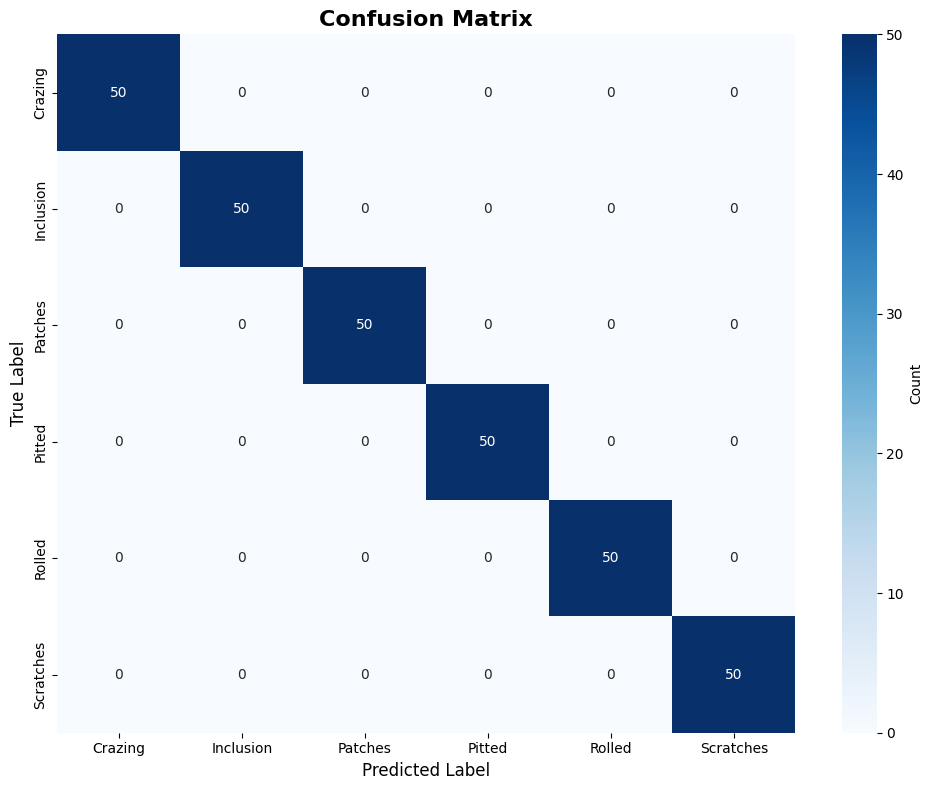

In [73]:
labels = confusion_matrix_data["data"]["class_labels"]
matrix = confusion_matrix_data["data"]["matrix"]
df_cm = pd.DataFrame(matrix, index=labels, columns=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, "confusion_matrix.png"))
plt.show()

In [78]:
matrix = np.array(confusion_matrix_data["data"]["matrix"])

metrics = []
n_classes = len(labels)

for i in range(n_classes):
    tp = matrix[i, i]
    fp = matrix[:, i].sum() - tp
    fn = matrix[i, :].sum() - tp
    tn = matrix.sum() - tp - fp - fn
    
    accuracy = (tp + tn) / matrix.sum() if matrix.sum() > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    support = matrix[i, :].sum()
    
    metrics.append({
        'Class': labels[i],
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Support': support
    })

df_metrics = pd.DataFrame(metrics)
total_support = matrix.sum()
weighted_precision = (df_metrics['Precision'] * df_metrics['Support']).sum() / total_support
weighted_recall = (df_metrics['Recall'] * df_metrics['Support']).sum() / total_support
weighted_f1 = (df_metrics['F1-Score'] * df_metrics['Support']).sum() / total_support
overall_accuracy = np.trace(matrix) / total_support

overall_row = pd.DataFrame([{
    'Class': 'Overall',
    'Precision': weighted_precision,
    'Recall': weighted_recall,
    'F1-Score': weighted_f1,
    'Support': total_support
}])

df_metrics = pd.concat([df_metrics, overall_row], ignore_index=True)

print("\n=== Classification Metrics ===")
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
print("\nPer-Class Metrics:")
df_metrics



=== Classification Metrics ===

Overall Accuracy: 1.0000

Per-Class Metrics:


,Class,Precision,Recall,F1-Score,Support
0,Crazing,1.0,1.0,1.0,50
1,Inclusion,1.0,1.0,1.0,50
2,Patches,1.0,1.0,1.0,50
3,Pitted,1.0,1.0,1.0,50
4,Rolled,1.0,1.0,1.0,50
5,Scratches,1.0,1.0,1.0,50
6,Overall,1.0,1.0,1.0,300


## 7. Register best model and deploy

### Create managed online endpoint

In [94]:
# Creating a unique endpoint name with current datetime to avoid conflicts
online_endpoint_name = "metal-defects-classification"
description = "Metal defects image classification"

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description=description,
    auth_mode="key",
    tags={"usecase": "metal defect", "type" : "computer vision", "product" : "azure ML", "ai": "image classification"},
)

In [95]:
start = time.time()

print("Create managed online endpoint...")
ml_client.begin_create_or_update(endpoint).result()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Create managed online endpoint...
✅ Done. Elapsed time = 1 minutes and 4 seconds


### Register best model and deploy

In [86]:
start = time.time()

print("Registering the best model...")
model_name = "metaldefect-imgclass-model"

model = Model(
    path=
    f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/mlflow-model/",
    name=model_name,
    description="Metal defects image classification model",
    type=AssetTypes.MLFLOW_MODEL,
)

registered_model = ml_client.models.create_or_update(model)

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Registering the best model...
✅ Done. Elapsed time = 0 minutes and 3 seconds


In [89]:
print(registered_model)

creation_context:
  created_at: '2025-10-14T16:17:08.302020+00:00'
  created_by: Serge Retkowsky
  created_by_type: User
  last_modified_at: '2025-10-14T16:17:08.302020+00:00'
  last_modified_by: Serge Retkowsky
  last_modified_by_type: User
description: Metal defects image classification model
flavors:
  python_function:
    artifacts: "{\n  \"model\": {\n    \"path\": \"artifacts/_model_impl_sn2b_xfl.pt\"\
      ,\n    \"uri\": \"/mnt/azureml/cr/j/461a9e9e9fe34a3b816b60eb4bac7fb3/exe/wd/_model_impl_sn2b_xfl.pt\"\
      \n  },\n  \"settings\": {\n    \"path\": \"artifacts/settings.json\",\n    \"\
      uri\": \"/mnt/azureml/cr/j/461a9e9e9fe34a3b816b60eb4bac7fb3/exe/wd/tmp4gxmybc3/settings.json\"\
      \n  }\n}"
    cloudpickle_version: 2.2.1
    code: ''
    env: "{\n  \"conda\": \"conda.yaml\",\n  \"virtualenv\": \"python_env.yaml\"\n\
      }"
    loader_module: mlflow.pyfunc.model
    python_model: python_model.pkl
    python_version: 3.9.7
    streamable: 'false'
id: azureml:/su

### Managed endpoint deployment

In [96]:
req_timeout = OnlineRequestSettings(request_timeout_ms=90000)

In [97]:
deployment = ManagedOnlineDeployment(
    name="metal-mlflow-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    instance_type="Standard_NC4as_T4_v3",
    instance_count=1,
    request_settings=req_timeout,
    liveness_probe=ProbeSettings(
        failure_threshold=30,
        success_threshold=1,
        timeout=2,
        period=10,
        initial_delay=2000,
    ),
    readiness_probe=ProbeSettings(
        failure_threshold=10,
        success_threshold=1,
        timeout=10,
        period=10,
        initial_delay=2000,
    ),
)

In [98]:
print("Starting to deploy the model ... Please wait.\n")

start = time.time()

ml_client.online_deployments.begin_create_or_update(deployment).result()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"\n✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Check: endpoint metal-defects-classification exists


Starting to deploy the model ... Please wait.

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
✅ Done. Elapsed time = 52 minutes and 16 seconds


In [99]:
print("Updating the deployment...\n")

start = time.time()

endpoint.traffic = {"metal-mlflow-deploy": 100}
ml_client.begin_create_or_update(endpoint).result()

elapsed = time.time() - start
minutes, seconds = divmod(elapsed, 60)
print(f"✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Updating the deployment...

✅ Done. Elapsed time = 1 minutes and 33 seconds


### Get endpoint details

In [100]:
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

In [102]:
print(endpoint)

auth_mode: key
description: Metal defects image classification
id: /subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourceGroups/azureml-testing-rg/providers/Microsoft.MachineLearningServices/workspaces/azuremltest/onlineEndpoints/metal-defects-classification
identity:
  principal_id: c24b9ff2-914e-4f3b-8023-a7fa4855bf38
  tenant_id: 16b3c013-d300-468d-ac64-7eda0820b6d3
  type: system_assigned
kind: Managed
location: westeurope
mirror_traffic: {}
name: metal-defects-classification
openapi_uri: https://metal-defects-classification.westeurope.inference.ml.azure.com/swagger.json
properties:
  AzureAsyncOperationUri: https://management.azure.com/subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/providers/Microsoft.MachineLearningServices/locations/westeurope/mfeOperationsStatus/oeidp:671b8e19-c2cc-4475-9e2e-750e3bfb46dd:e7682f10-fb64-4632-acd6-c18b17fc1407?api-version=2022-02-01-preview
  azureml.onlineendpointid: /subscriptions/b8acd8e6-3841-4717-8469-82e36dad9ae5/resourcegroups/azu

In [103]:
print(f"🎯 Endpoint traffic details: {endpoint.traffic}")

🎯 Endpoint traffic details: {'metal-mlflow-deploy': 100}


In [104]:
print(f"🏅 Endpoint scoring URI: {endpoint.scoring_uri}")

🏅 Endpoint scoring URI: https://metal-defects-classification.westeurope.inference.ml.azure.com/score


## 8. Testing the model

In [105]:
def image_classification(image_file):
    """
    Retrieve model predictions for a given image sample.
    """
    try:
        print(f"Analyzing {image_file}")
        payload = {
            "input_data": {
                "columns": ["image"],
                "data": [
                    base64.encodebytes(
                        open(image_file, "rb").read()
                    ).decode("utf-8")
                ],
            }
        }

        # Save request to JSON file
        request_filename = os.path.join(RESULTS_DIR, "sample_request_data_classification.json")
    
        with open(request_filename, "w") as file:
            json.dump(payload, file)

        # Invoke the ML endpoint
        response = ml_client.online_endpoints.invoke(
            endpoint_name=online_endpoint_name,
            deployment_name=deployment.name,
            request_file=request_filename,
        )

        # Parse and extract prediction results
        results = json.loads(response)[0]

        max_index = results['probs'].index(max(results['probs']))
        print("\033[1;31;34m")
        print(f"Prediction: {results['labels'][max_index].upper()} with score = {results['probs'][max_index]:.5f}")
        return results
    
    except:
        return None

### Examples

In [106]:
test_images_list = [
        str(file) for file in Path(TEST_DIR).rglob('*')
        if file.suffix.lower() in {".jpg", ".jpeg", ".png", ".gif", ".bmp"}
]

len(test_images_list)

180

### Example 1

images/metaldefect/test/Crazing/cr_246.jpg


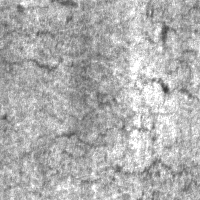

In [150]:
image_file = test_images_list[0]
print(image_file)

img = Image.open(image_file)
img

In [151]:
start = time.time()

results = image_classification(image_file)

print(f"\n✅ Done in {(time.time() - start):.3f} seconds")

Analyzing images/metaldefect/test/Crazing/cr_246.jpg

Prediction: CRAZING with score = 0.99979

✅ Done in 0.818 seconds


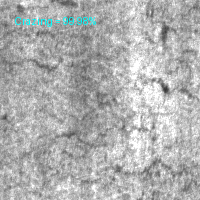

In [152]:
max_idx = np.argmax(results['probs'])
predicted_label = results['labels'][max_idx]
predicted_prob = results['probs'][max_idx]

img = Image.open(image_file)
draw = ImageDraw.Draw(img)
text = f"{predicted_label} = {predicted_prob:.2%}"
font = ImageFont.load_default()
position = (15, 15)
draw.text(position, text, fill='cyan', font=font)

img

In [153]:
df = pd.DataFrame({'label': results['labels'], 'probability': results['probs']})
df.sort_values(by='probability', ascending=False)

,label,probability
0,Crazing,9.997862e-01
2,Patches,2.084246e-04
4,Rolled,3.992910e-06
3,Pitted,8.401196e-07
5,Scratches,3.729057e-07
1,Inclusion,1.161245e-07


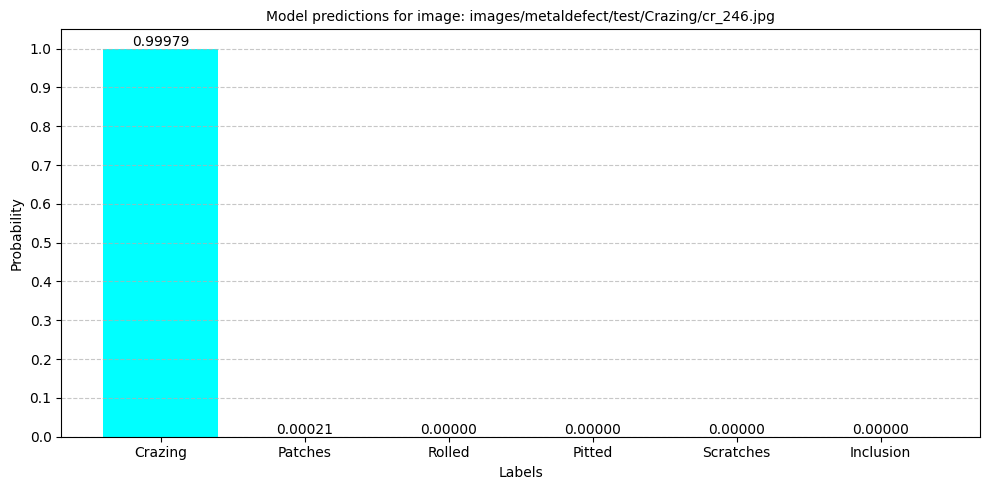

In [154]:
df_sorted = df.sort_values(by='probability', ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.bar(df_sorted['label'], df_sorted['probability'], color='cyan')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.5f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([i/10 for i in range(11)])
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title(f'Model predictions for image: {image_file}', size=10)
plt.tight_layout()
plt.show()

### Example 2

images/metaldefect/test/Inclusion/in_271.jpg


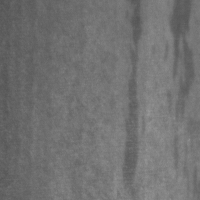

In [155]:
image_file = test_images_list[55]
print(image_file)

img = Image.open(image_file)
img

In [156]:
start = time.time()

results = image_classification(image_file)

print(f"\n✅ Done in {(time.time() - start):.3f} seconds")

Analyzing images/metaldefect/test/Inclusion/in_271.jpg

Prediction: INCLUSION with score = 0.99972

✅ Done in 1.023 seconds


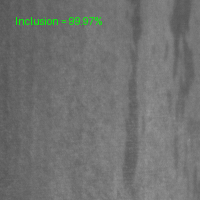

In [157]:
max_idx = np.argmax(results['probs'])
predicted_label = results['labels'][max_idx]
predicted_prob = results['probs'][max_idx]

img = Image.open(image_file)
draw = ImageDraw.Draw(img)
text = f"{predicted_label} = {predicted_prob:.2%}"
font = ImageFont.load_default()
position = (15, 15)
draw.text(position, text, fill='lime', font=font)

img

In [158]:
df = pd.DataFrame({'label': results['labels'], 'probability': results['probs']})
df.sort_values(by='probability', ascending=False)

,label,probability
1,Inclusion,9.997225e-01
3,Pitted,1.574408e-04
5,Scratches,9.918404e-05
2,Patches,2.004372e-05
4,Rolled,6.121440e-07
0,Crazing,2.284008e-07


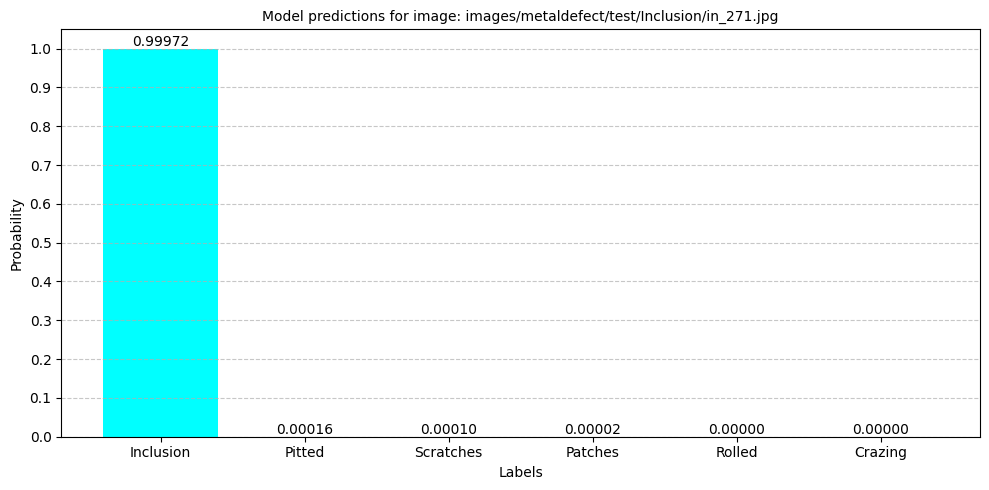

In [159]:
df_sorted = df.sort_values(by='probability', ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.bar(df_sorted['label'], df_sorted['probability'], color='cyan')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.5f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([i/10 for i in range(11)])
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title(f'Model predictions for image: {image_file}', size=10)
plt.tight_layout()
plt.show()

### Example 3

images/metaldefect/test/Pitted/pi_256.jpg


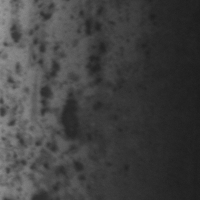

In [160]:
image_file = test_images_list[100]
print(image_file)

img = Image.open(image_file)
img

In [161]:
start = time.time()

results = image_classification(image_file)

print(f"\n✅ Done in {(time.time() - start):.3f} seconds")

Analyzing images/metaldefect/test/Pitted/pi_256.jpg

Prediction: PITTED with score = 0.99988

✅ Done in 0.982 seconds


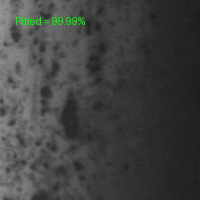

In [163]:
max_idx = np.argmax(results['probs'])
predicted_label = results['labels'][max_idx]
predicted_prob = results['probs'][max_idx]

img = Image.open(image_file)
draw = ImageDraw.Draw(img)
text = f"{predicted_label} = {predicted_prob:.2%}"
font = ImageFont.load_default()
position = (15, 15)
draw.text(position, text, fill='lime', font=font)

img

In [164]:
df = pd.DataFrame({'label': results['labels'], 'probability': results['probs']})
df.sort_values(by='probability', ascending=False)

,label,probability
3,Pitted,9.998845e-01
5,Scratches,7.463805e-05
2,Patches,3.876098e-05
1,Inclusion,1.002276e-06
4,Rolled,7.673101e-07
0,Crazing,2.732737e-07


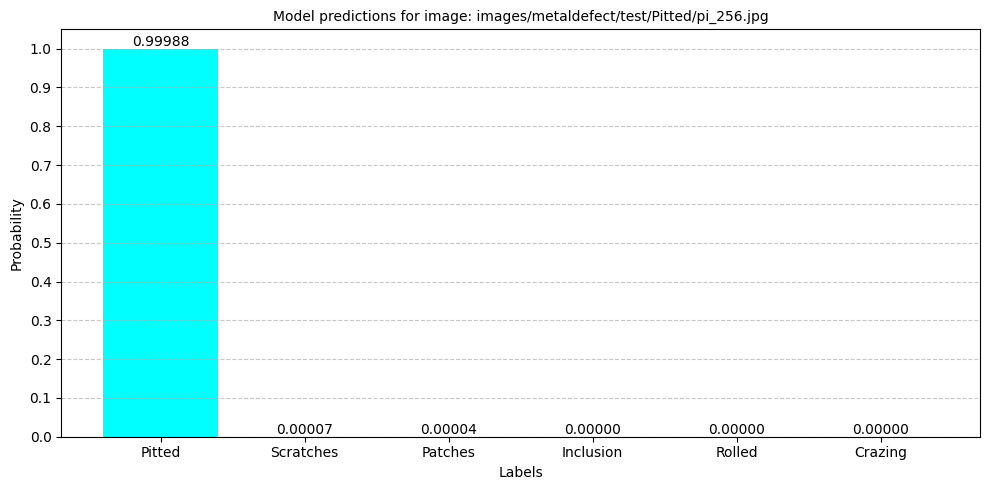

In [165]:
df_sorted = df.sort_values(by='probability', ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.bar(df_sorted['label'], df_sorted['probability'], color='cyan')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.5f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([i/10 for i in range(11)])
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title(f'Model predictions for image: {image_file}', size=10)
plt.tight_layout()
plt.show()

### Example 4

images/metaldefect/test/Scratches/sc_246.jpg


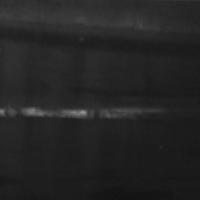

In [166]:
image_file = test_images_list[150]
print(image_file)

img = Image.open(image_file)
img

In [167]:
start = time.time()

results = image_classification(image_file)

print(f"\n✅ Done in {(time.time() - start):.3f} seconds")

Analyzing images/metaldefect/test/Scratches/sc_246.jpg

Prediction: SCRATCHES with score = 0.99997

✅ Done in 0.942 seconds


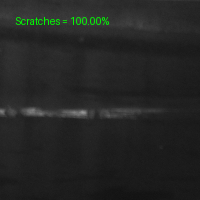

In [168]:
max_idx = np.argmax(results['probs'])
predicted_label = results['labels'][max_idx]
predicted_prob = results['probs'][max_idx]

img = Image.open(image_file)
draw = ImageDraw.Draw(img)
text = f"{predicted_label} = {predicted_prob:.2%}"
font = ImageFont.load_default()
position = (15, 15)
draw.text(position, text, fill='lime', font=font)

img

In [169]:
df = pd.DataFrame({'label': results['labels'], 'probability': results['probs']})
df.sort_values(by='probability', ascending=False)

,label,probability
5,Scratches,9.999728e-01
2,Patches,1.087738e-05
1,Inclusion,8.429697e-06
3,Pitted,7.590140e-06
4,Rolled,1.021600e-07
0,Crazing,5.735598e-08


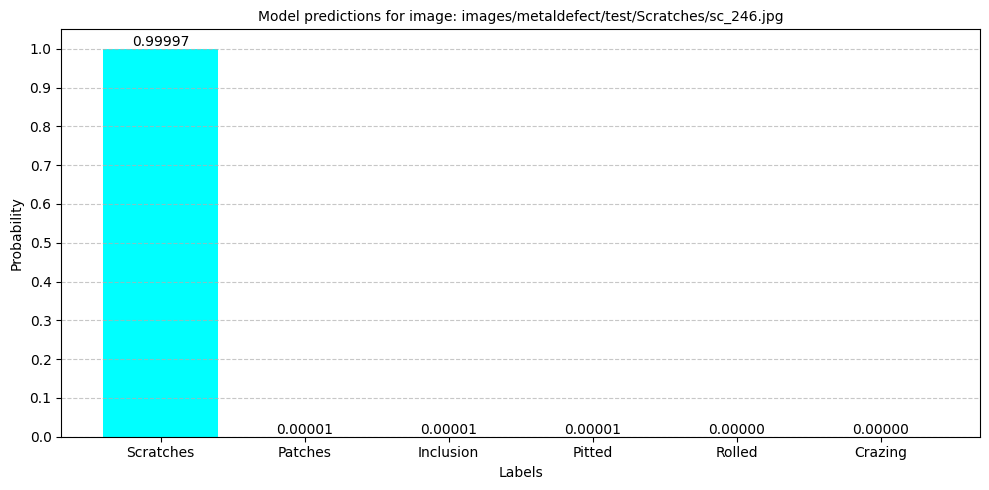

In [170]:
df_sorted = df.sort_values(by='probability', ascending=False)

plt.figure(figsize=(10, 5))
bars = plt.bar(df_sorted['label'], df_sorted['probability'], color='cyan')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.5f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yticks([i/10 for i in range(11)])
plt.xlabel('Labels')
plt.ylabel('Probability')
plt.title(f'Model predictions for image: {image_file}', size=10)
plt.tight_layout()
plt.show()

### Generate the Scores and Explanations
- Explainability methods:
   - [XRAI](https://arxiv.org/abs/1906.02825) (xrai)
   - [Integrated Gradients](https://arxiv.org/abs/1703.01365) (integrated_gradients)
   - [Guided GradCAM](https://arxiv.org/abs/1610.02391v4) (guided_gradcam)
   - [Guided BackPropagation](https://arxiv.org/abs/1412.6806) (guided_backprop)

For more details on explainability with AutoML for images, refer to the [generating explanations](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models?tabs=python#generate-explanations-for-predictions) and [schema](https://learn.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema#data-format-for-online-scoring-and-explainability-xai) articles.

In [196]:
image_file = test_images_list[170]

In [197]:
def read_image(image_path):
    """
    Reading image
    """
    with open(image_path, "rb") as f:
        return f.read()

In [198]:
def base64_to_img(base64_img_str):
    """
    Base64 to image
    """
    base64_img = base64_img_str.encode("utf-8")
    decoded_img = base64.b64decode(base64_img)

    return BytesIO(decoded_img).getvalue()

In [199]:
# Define explainability (XAI) parameters
model_explainability = True
xai_parameters = {
    "xai_algorithm": "xrai",
    "visualizations": True,
    "attributions": False,
}

# Create request json
request_json = {
    "input_data": {
        "columns": ["image"],
        "data": [
            json.dumps({
                "image_base64":
                base64.encodebytes(read_image(image_file)).decode("utf-8"),
                "model_explainability":
                model_explainability,
                "xai_parameters":
                xai_parameters,
            })
        ],
    }
}

request_file_name = os.path.join(RESULTS_DIR, "sample_request_data_classification.json")
with open(request_file_name, "w") as request_file:
    json.dump(request_json, request_file)
    
resp = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name=deployment.name,
    request_file=request_file_name,
)

predictions = json.loads(resp)

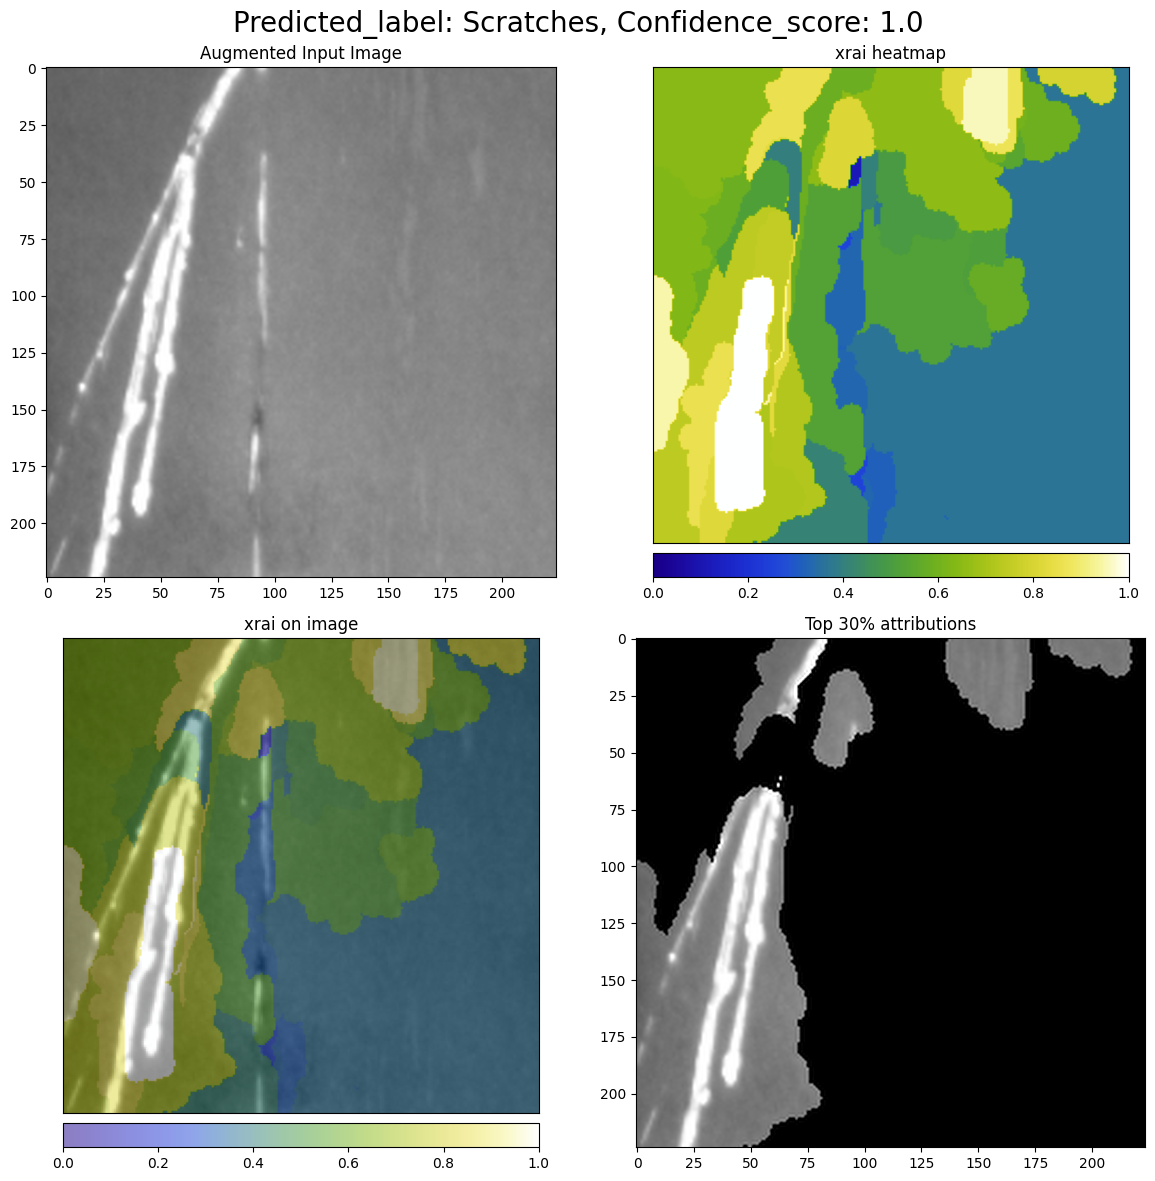

In [200]:
# Visualize explanations of the first image against one of the class
img_bytes = base64_to_img(predictions[0]["visualizations"])
img = Image.open(BytesIO(img_bytes))
img.save(os.path.join(RESULTS_DIR, "explanations.png"))

display(img)

## Gradio webapp

In [186]:
def gradio_fn(image_file):
    """
    Process uploaded image and return classification predictions
    """
    start = time.time()
    predictions = image_classification(image_file)
    msg = f"[{datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}] Done in {(time.time() - start):.3f} seconds"
    
    return dict(zip(predictions['labels'], predictions['probs'])), msg

In [187]:
# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft()) as webapp:
    gr.Markdown(
        """
        # 🖼️ Image Classification webapp
        Upload an image to get image defect predictions using Azure AutoML for Images
        """
    )
    
    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(
                label="Upload Image",
                type="filepath",
                height=400
            )
            classify_btn = gr.Button("Classify Image", variant="primary", size="lg")
            clear_btn = gr.ClearButton([image_input], value="Clear")
        
        with gr.Column(scale=1):
            label_output = gr.Label(
                label="Predictions",
            )
            message_output = gr.Textbox(
                label="Processing Time",
                interactive=False,
                lines=1,
            )
    
    # Connect the function to the button
    classify_btn.click(
        fn=gradio_fn,
        inputs=image_input,
        outputs=[label_output, message_output]
    )
    
    # Add examples (optional)
    gr.Markdown("### 💡 Tips")
    gr.Markdown(
        """
        - Supported formats: JPG, PNG, JPEG
        - For best results, use clear, well-lit images
        """
    )

In [188]:
# Create and set new event loop
loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

In [189]:
webapp.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://2fb0a6c2d92b0a966f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<img src="img/webapp1.jpg">

<img src="img/webapp2.jpg">